In [4]:
import numpy as np
import torch
from sklearn.gaussian_process.kernels import ConstantKernel, Matern

from typing import Tuple, List, Optional

In [5]:
import matplotlib.pyplot as plt
plt.style.use('bmh')

In [6]:
def matern_covariance(
    t: int,
    length_scale: float,
    nu: float,
    *,
    sigma2: float = 1.0,
    jitter: float = 1e-8
) -> torch.Tensor:
    """
    Return a t x t Matérn covariance matrix over integer index positions 0 to t-1.
    """
    # Build kernel with free variance
    kernel = ConstantKernel(constant_value=sigma2) * Matern(length_scale=length_scale, nu=nu)
    # Locations in index space → shape (n,1)
    X = np.arange(t, dtype=float).reshape(-1, 1)
    # Evaluate and stabilize (to later draw samples, need a positive-definite Σ. 
    # Floating-point rounding can produce a single negative eigenvalue.)
    vcov = kernel(X)              # equivalent to k(X, X)
    np.fill_diagonal(vcov, vcov.diagonal() + jitter)
    return torch.as_tensor(vcov)

# """ def matern_series(B, T, offset=2, **kernel_kwargs) -> np.ndarray:
#     """
#     Generate a set of B Matérn series of length T with a given offset (mean).
#     """
#     vcov = matern_covariance(T, **kernel_kwargs)
#     return np.random.multivariate_normal(np.ones(T) * offset, vcov, size=B) """
    
    
def random_ts_params(mode: int) -> Tuple[float, float]:
    """
    Generate random time series parameters for slow, medium, or fast dynamics
    """    
    if mode not in {0, 1, 2}:
        raise ValueError("mode must be 0 (slow), 1 (medium) or 2 (fast)")

    scale_ranges = {
        0: (50.0, 100.0),   # slow
        1: (10.0, 20.0),    # medium
        2: (1.0, 4.0),      # fast
    }

    scale_low, scale_high = scale_ranges[mode]
    nu_low, nu_high = 0.5, 8.0     # nu controls the smoothness (noise level)
    
    scale = (torch.rand(()) * (scale_high - scale_low) + scale_low).item()
    nu    = (torch.rand(()) * (nu_high - nu_low) + nu_low).item() 

    return scale, nu

In [7]:
def _even_partition(total: int, k: int) -> List[int]:
    """
    Split `total` into `k` integer parts whose sizes differ by at most 1.
    Assumes 1 ≤ k ≤ total.
    """
    base, extra = divmod(total, k)
    return [base + (i < extra) for i in range(k)]

In [8]:
def generate_V(r: int,
               m: int,
               row_sizes: List[int],
               *,
               strong_mean: float = 3.0,
               strong_std:  float = 0.75,
               weak_mean:  float = 0.0,
               weak_std:   float = 1.0,
               shuffle_columns: bool = True,
               seed: int | None = None) -> torch.Tensor:
    if r <= 0 or m <= 0:
        raise ValueError("r and m must be positive integers")
    if r > m:
        raise ValueError("r should not exceed m for block construction")
    if seed is not None:
        torch.manual_seed(seed)

    # determine block sizes
    if not row_sizes:
        row_sizes = _even_partition(r, min(r, 3))
    col_sizes = _even_partition(m, min(m, 3))   # three column-blocks

    # build logits tensor
    logits = torch.normal(mean=weak_mean, std=weak_std, size=(r, m))

    # mark the starts of each column block once for efficiency
    col_starts = [0]                    
    for sz in col_sizes[:-1]:             
        col_starts.append(col_starts[-1] + sz)

    # overwrite the diagonal blocks with “high” logits
    row_start = 0
    for block in range(len(row_sizes)):
        row_end = row_start + row_sizes[block]
        col_start = col_starts[block]
        col_end   = col_start + col_sizes[block]

        # Set strong logits for the diagonal block
        logits[row_start:row_end, 
               col_start:col_end] = torch.normal(
                   mean=strong_mean,
                   std=strong_std,
                   size=(row_sizes[block], col_sizes[block])
               )
        row_start = row_end

    # optional column shuffling
    if shuffle_columns:
        perm = torch.randperm(m)
        logits = logits[:, perm]

    # softmax over rows
    V = torch.softmax(logits, dim=0) 

    return V


In [9]:
def generate_DGP(
    t: int,
    m: int,
    r: int,
    *,
    seed: Optional[int] = None,
) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Define a random data-generating process comprised of the following
    parameters:
    - r Matérn autocovariance matrices of size t x t (one for each column of U)
    - A mixing weight matrix V of size r x m
    
    with a shared division of the rank r into up to three blocks  
        representing slow, medium, and fast dynamics
        (ie, a list of integers r1, r2, r3 such that r = r1 + r2 + r3)
    """
    if seed is not None:
        torch.manual_seed(seed)

    nblocks = min(r, 3)           # 1, 2, or 3 blocks
    block_sizes: List[int] = _even_partition(r, nblocks)

    modes = torch.repeat_interleave(torch.arange(nblocks), torch.tensor(block_sizes))
    
    vcov_list = [
        matern_covariance(t, *random_ts_params(int(mode)))
        for mode in modes
    ]
    vcovU = torch.stack(vcov_list, dim=0)  # r x t x t 
    V = generate_V(r, m, block_sizes, seed=seed)
    return vcovU, V

In [10]:
def gen_Us_col(vcovU: torch.Tensor,
               realizations: int = 1,
               *, 
               offset: float = 2.0,
               seed: Optional[int] = None) -> torch.Tensor:
    t = vcovU.shape[1]
    if seed is not None:
        torch.manual_seed(seed)
    mvn = torch.distributions.MultivariateNormal(
        loc=torch.full((t,), offset),
        covariance_matrix=vcovU
    )
    Us_col = mvn.rsample((realizations,)) 
    return Us_col

def gen_U_col(vcovU: torch.Tensor,
               *, 
               offset: float = 2.0,
               seed: Optional[int] = None) -> torch.Tensor:
    t = vcovU.shape[1]
    if seed is not None:
        torch.manual_seed(seed)
    mvn = torch.distributions.MultivariateNormal(
        loc=torch.full((t,), offset, dtype=vcovU.dtype),
        covariance_matrix=vcovU
    )
    U_col = mvn.rsample() 
    return U_col

def generate_U(vcovsU: torch.Tensor,
               *, 
               offset: float = 2.0,
               seed: Optional[int] = None):
    r, t, _ = vcovsU.shape
    U = torch.zeros(t, r)
    for col in range(r):
        U[:, col] = gen_U_col(vcovsU[col], offset=offset, seed=seed)
    return U


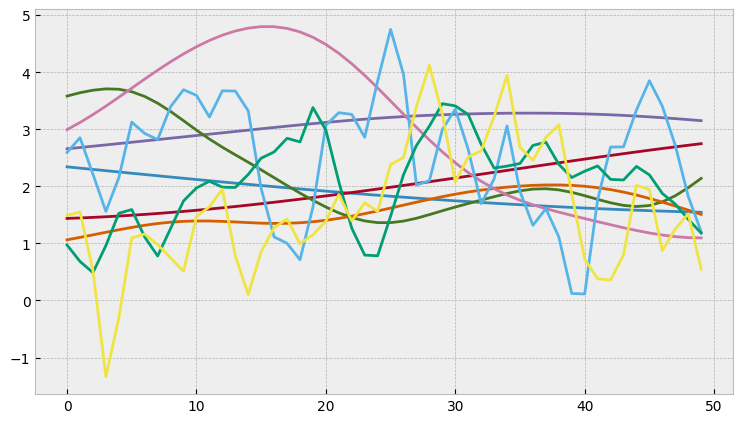

In [36]:
t = 50
r = 9
m = 25
vcovsU, V = generate_DGP(t = t, m = m, r = r)
U = generate_U(vcovsU)
# Plot each column as a line graph
fig, ax = plt.subplots(1, 1, figsize=(9, 5))
for col in range(r):
    ax.plot(U[:, col], label='U_{}'.format(col))
    #ax.legend()
plt.show()

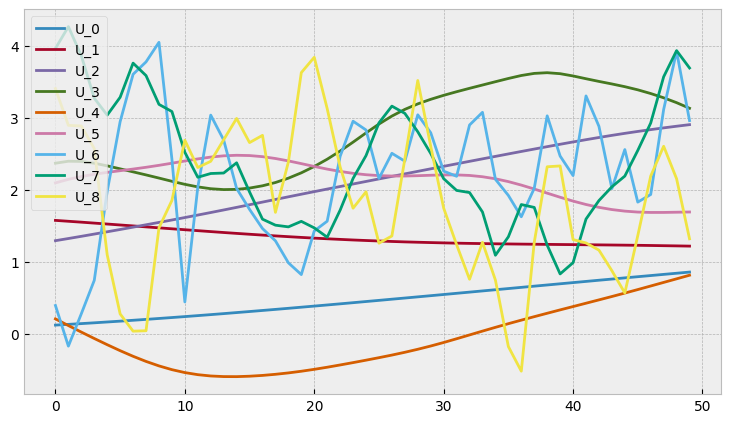

In [37]:
U = generate_U(vcovsU)
# Plot each column as a line graph
fig, ax = plt.subplots(1, 1, figsize=(9, 5))
for col in range(r):
    ax.plot(U[:, col], label='U_{}'.format(col))
    ax.legend()
plt.show()

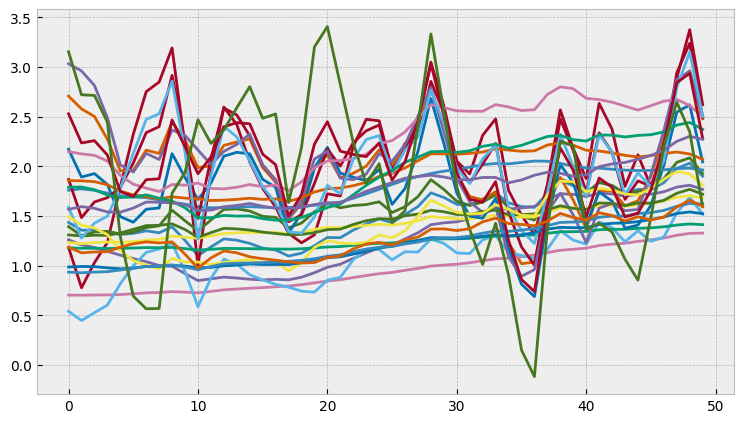

In [38]:
M = U @ V

fig, ax = plt.subplots(1, 1, figsize=(9, 5))
for col in range(m):
    ax.plot(M[:, col])
plt.show()

In [39]:
# assume each column is a price time series -- compute returns
def fin_return(val_start, val_end):
    return (val_end - val_start) / val_start

# generate a new matrix of returns with one fewer row than M
M_rets = fin_return(M[:-1, :], M[1:, :])

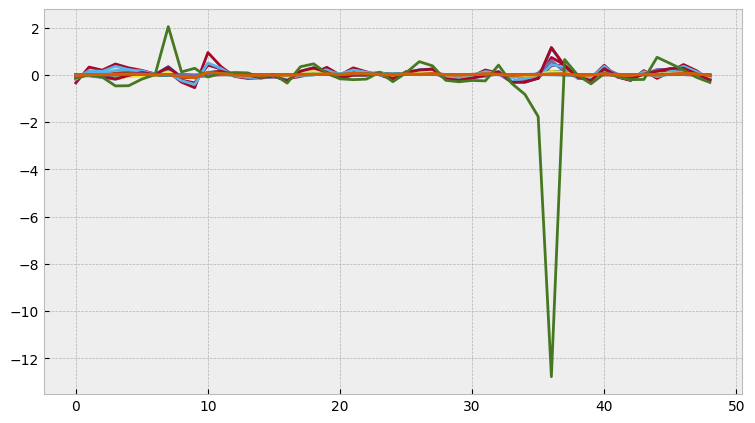

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(9, 5))
for col in range(m):
    ax.plot(M_rets[:, col])
plt.show()

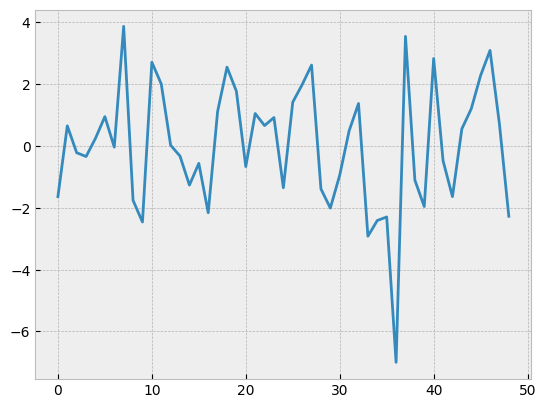

In [41]:
plt.plot(M_rets.sum(dim = 1))

In [ ]:
t = 30
r = 9
m = 15
realizations = 10

vcovsU, V = generate_DGP(t = t, m = m, r = r)
Us = torch.zeros((realizations, t, r))
for i in range(realizations):
    Us[i] = generate_U(vcovsU)
Us.shape

torch.Size([10, 30, 9])

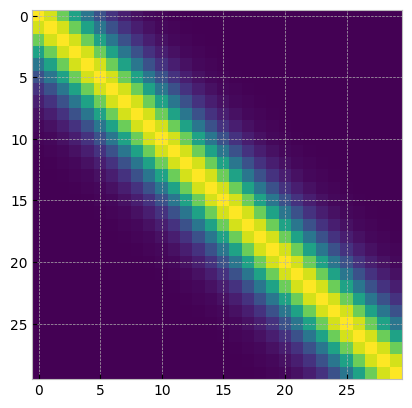

In [209]:
plt.imshow(vcovsU[8])

In [ ]:
num_dgps = 5

vcovsUs = torch.zeros((num_dgps, r, t, t))
Us = torch.zeros((realizations * num_dgps, t, r))
Vs = torch.zeros((realizations * num_dgps, r, m))
for dgp in range(num_dgps):
    vcovsU, V = generate_DGP(t = t, m = m, r = r)
    vcovsUs[dgp] = vcovsU
    for i in range(realizations):
        idx = dgp * realizations + i
        Us[idx] = generate_U(vcovsU)
        Vs[idx] = V
Us.shape, Vs.shape, vcovsUs.shape